# Find Anything in Images with Just Words

### 🧠 What is Grounding DINO?

Grounding DINO is an open-source AI model that allows you to **point out objects in images using text prompts**. You don’t need to label images in advance or write any machine learning code — just write what you’re looking for, and the model highlights it.

Think of it as a way to "search inside an image" using your own words.

---

### 💡 Why it matters

Traditional object detection tools are limited to predefined categories like "car" or "cat". Grounding DINO goes further — it understands open-ended descriptions like:

- `"left woman"`
- `"Women with glasses"`
- `"Man with a bowtie"`

This makes it much more flexible and useful in real-world tasks where object categories aren’t fixed or known in advance.

### Step 1: Install required python libraries

In [ ]:
# --- install once ---
!pip install \
    diffusers==0.35.2 \
    transformers==4.57.2 \
    huggingface_hub==0.36.0 \
    accelerate==1.12.0 \
    timm==1.0.22 \
    safetensors==0.7.0 \
    pillow==11.3.0 \
    opencv-python==4.12.0.88



### Step 2: Import libraries needed

In [ ]:
import torch, cv2
import numpy as np
from PIL import Image
import requests, io
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt


### Step 3: Prepare util functions

In [ ]:
def run_grounding_dino(image, text, model, processor, device="cuda", box_thr=0.4, text_thr=0.3):
    """
    Run GroundingDINO on a given image and a single text prompt.

    Args:
        image (PIL.Image): input image
        text (str): text prompt, e.g. "person"
        model: loaded AutoModelForZeroShotObjectDetection
        processor: loaded AutoProcessor
        device (str): "cuda" or "cpu"
        box_thr (float): threshold for box confidence
        text_thr (float): threshold for text confidence

    Returns:
        PIL.Image with boxes drawn
        results dict from post_process
    """
    # prepare inputs
    inputs = processor(images=image, text=text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # postprocess
    W, H = image.size  # PIL gives (width, height)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=box_thr,
        text_threshold=text_thr,
        target_sizes=[(H, W)],
    )[0]

    # handle labels
    labels_out = results.get("text_labels", results.get("labels", []))

    # draw boxes
    img_np = np.array(image).copy()
    for box, label, score in zip(results["boxes"], labels_out, results["scores"]):
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{label} ({score:.2f})", (x1, max(0, y1 - 6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

    return Image.fromarray(img_np), results, inputs


def show_image(image, title=None, size=8):
    plt.figure(figsize=(size, size))
    plt.imshow(image)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

### Step 4: Load the model

Note: this step might take a while. Since this step downloads a large model, it can take a significant amount of time to complete. If the download appears to be stuck (no progress for a long time) these steps can help out:

1. Interrupt the cell and run it again (you may need to retry a couple of times).
2. If it still doesn’t work, restart the runtime, then run all previous cells before executing this one again.

In [ ]:
model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

### Step 5: Test the model on image

Example image is located inside psiml-applied-ai repository so we need to get that

In [ ]:
!git clone https://github.com/pfe-rs/psiml-applied-ai.git

Cloning into 'psiml-applied-ai'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 102 (delta 46), reused 75 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 10.04 MiB | 23.10 MiB/s, done.
Resolving deltas: 100% (46/46), done.


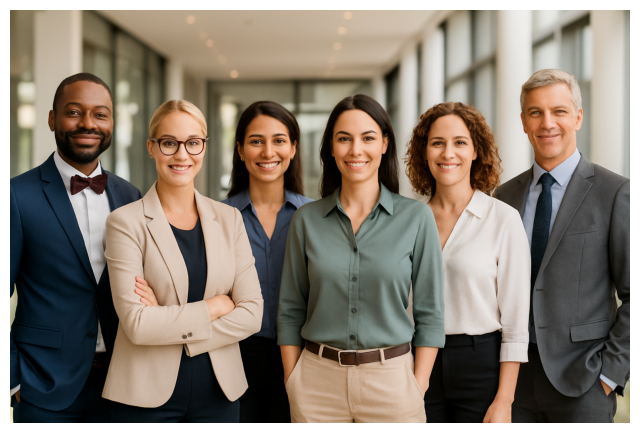

In [ ]:
img_url = r"/content/psiml-applied-ai/notebooks/attachments/example_img.png"
image = Image.open(img_url).convert("RGB")
show_image(image)

/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:98: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


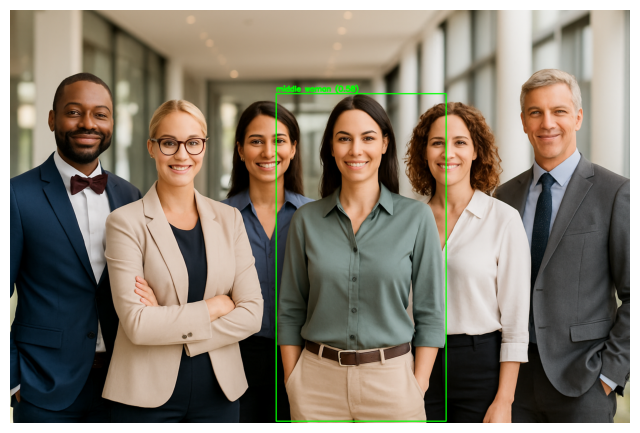

In [ ]:
prompt = ["middle woman"]
vis_img, detections, inputs = run_grounding_dino(image, prompt, model, processor, device)
show_image(vis_img)

In [ ]:
print("Inputs:", inputs)
print("Outputs:", detections)

Inputs: {'pixel_values': tensor([[[[-0.2342, -0.2342, -0.2171,  ...,  0.0056, -0.0801, -0.1999],
          [-0.2171, -0.2342, -0.1999,  ...,  0.0398, -0.0629, -0.1999],
          [-0.2513, -0.2513, -0.2342,  ...,  0.0569, -0.0458, -0.1314],
          ...,
          [ 2.0777,  2.0434,  2.0777,  ...,  0.5878,  0.5878,  0.5707],
          [ 2.0777,  2.0777,  2.0777,  ...,  0.5707,  0.5536,  0.5364],
          [ 2.0263,  2.0434,  2.0605,  ...,  0.5707,  0.5536,  0.5364]],

         [[-0.3901, -0.3901, -0.3901,  ...,  0.0826, -0.0049, -0.0924],
          [-0.3725, -0.3725, -0.4076,  ...,  0.1176,  0.0301, -0.0749],
          [-0.4076, -0.4076, -0.3901,  ...,  0.1352,  0.0476, -0.0399],
          ...,
          [ 2.1660,  2.1485,  2.1660,  ...,  0.5728,  0.6078,  0.5903],
          [ 2.1485,  2.1835,  2.1835,  ...,  0.5728,  0.5728,  0.5553],
          [ 2.1310,  2.1660,  2.1835,  ...,  0.5378,  0.5203,  0.5203]],

         [[-0.6890, -0.6890, -0.7064,  ...,  0.0256, -0.0267, -0.1312],
     

# Tokens

https://huggingface.co/spaces/Xenova/the-tokenizer-playground

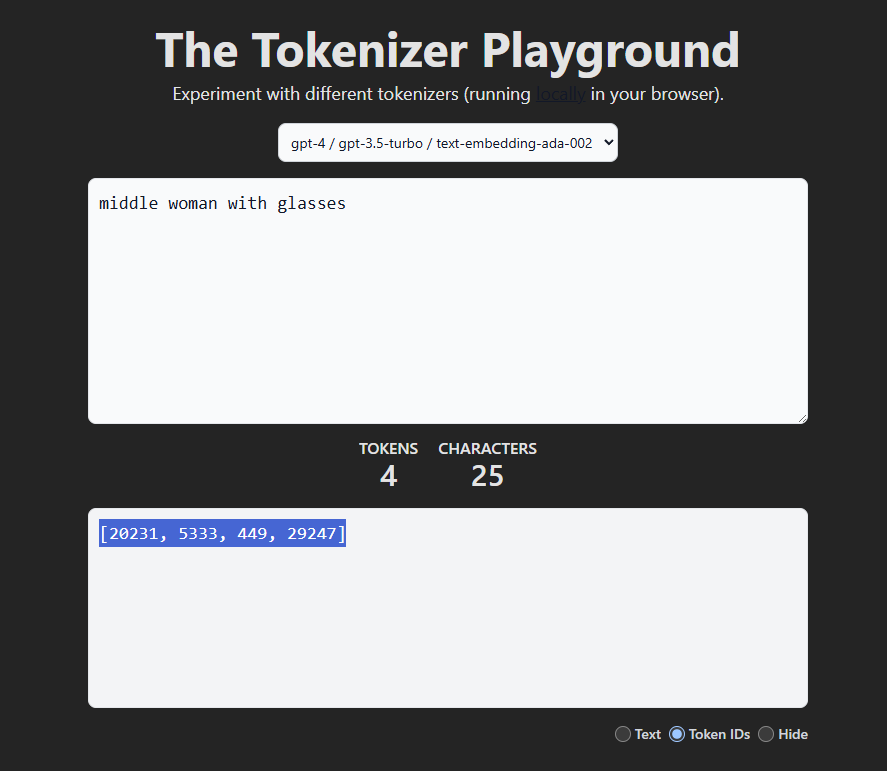



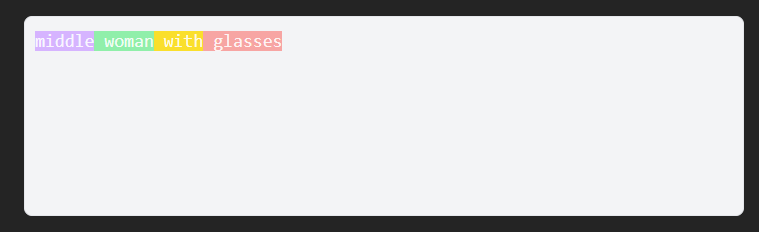

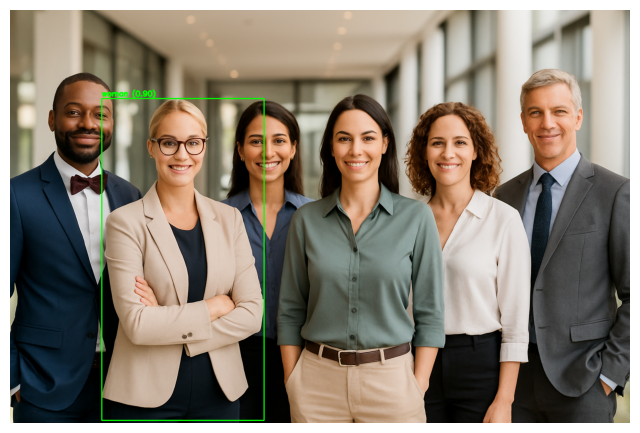

In [ ]:
prompt = ["woman with glasses"]
vis_img, detections, inputs2 = run_grounding_dino(image, prompt, model, processor, device)
show_image(vis_img)


In [ ]:
print("Inputs1:", inputs['input_ids'])
print("Inputs2:", inputs2['input_ids'])

Inputs1: tensor([[ 101, 2690, 2450, 1012,  102]], device='cuda:0')
Inputs2: tensor([[ 101, 2450, 2007, 7877, 1012,  102]], device='cuda:0')


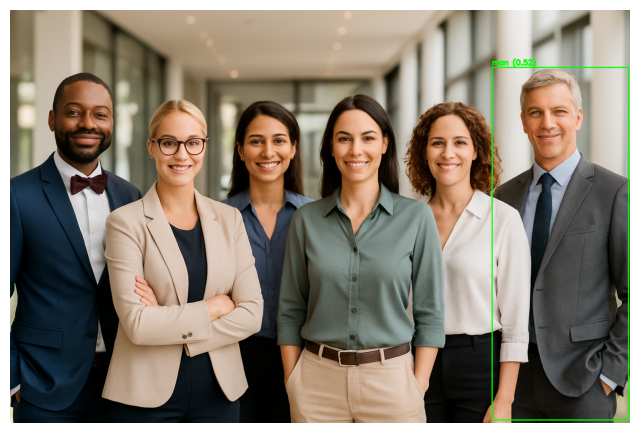

In [ ]:
prompt = ["man with a tie"]
vis_img, detections, _ = run_grounding_dino(image, prompt, model, processor, device)
show_image(vis_img)

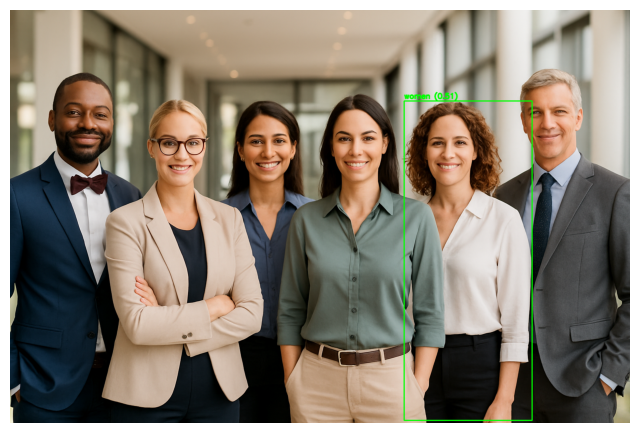

In [ ]:
prompt = ["Women on the right"]
vis_img, detections, _ = run_grounding_dino(image, prompt, model, processor, device)
show_image(vis_img)

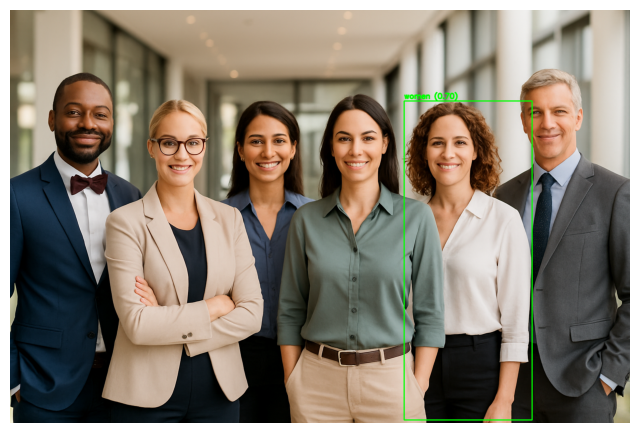

In [ ]:
prompt = ["Women on the far right"]
vis_img, detections, _ = run_grounding_dino(image, prompt, model, processor, device)
show_image(vis_img)

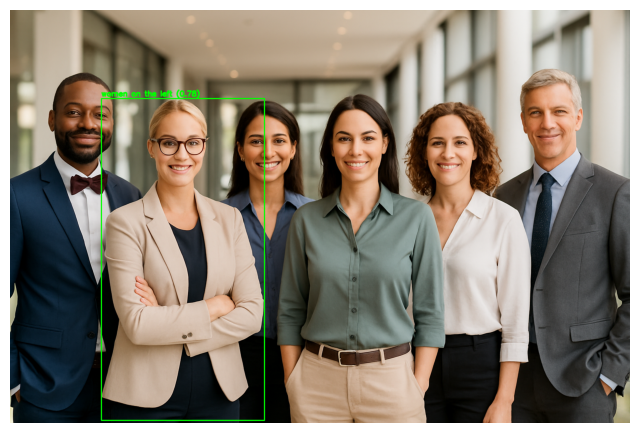

In [ ]:
prompt = ["Women on the left"]
vis_img, detections, _ = run_grounding_dino(image, prompt, model, processor, device)
show_image(vis_img)

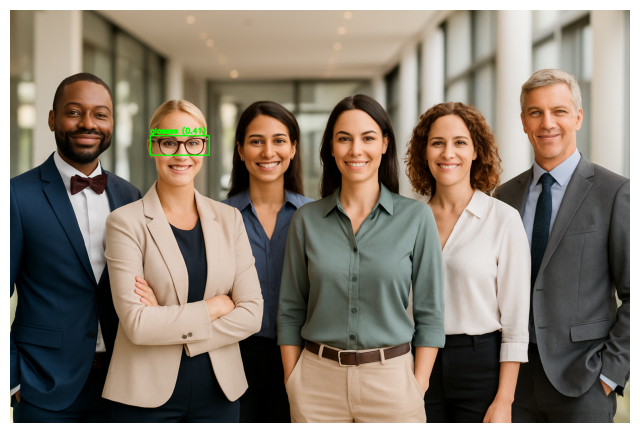

In [ ]:
prompt = ["glasses"]
vis_img, detections, _ = run_grounding_dino(image, prompt, model, processor, device)
show_image(vis_img)


Clean memory

In [ ]:
import torch
import gc

# 1. Delete the model and processor objects
del model
del processor

# 2. Run garbage collection to remove Python references
gc.collect()

# 3. Empty CUDA cache to release GPU VRAM
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Stable diffusion

⭐ Stable Diffusion

Stable Diffusion is a modern text-to-image generative model that creates realistic images based on natural-language descriptions. You type a prompt like “a futuristic city at sunset, ultra-detailed” and the model synthesizes a completely new image that matches your description.

Unlike earlier models, Stable Diffusion works in a latent space — a compressed representation of images — which makes it much more efficient and capable of running on consumer GPUs.

###
### Types of Diffusion Models

Diffusion models can work in different ways depending on the task.

Text-to-Image
These models generate a completely new image starting from random noise, guided only by a text prompt.

Inpainting
Given an image and a mask (the part that should change), the model fills in the missing or edited region while keeping the rest of the image intact.

Outpainting
The model expands an image beyond its original borders, creating new content that matches the existing style and scene.

Image-to-Image (img2img)
You provide an input image and a text prompt, and the model produces a new image that follows your description while preserving the structure of the original.

Control-Guided Diffusion (ControlNet)
These models take extra inputs such as depth maps, edges, poses, or scribbles, and use them to control the composition of the final image.

Video Diffusion Models
These models apply the same process across multiple frames to generate or edit videos with temporal consistency.

### Step 1: Install and import libraries

In [ ]:
import torch, numpy as np, cv2
from PIL import Image
from diffusers import AutoPipelineForInpainting, AutoPipelineForText2Image

device = "cuda" if torch.cuda.is_available() else "cpu"

### Step 2: Text2Image example

Similarly to the Grounding DINO example, the next cell also downloads a large model which can result in the cell getting stuck. If that happens perform the same solution as already described in the fourth step of the Grounding DINO example.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

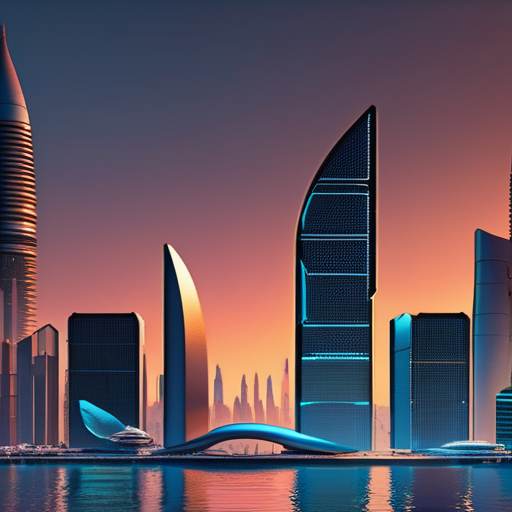

In [ ]:

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    variant="fp16",
).to(device)

# --- disable NSFW checker (optional) ---
def dummy_safety(images, **kwargs):
    return images, [False] * len(images)

pipe.safety_checker = dummy_safety

# --- generate an image ---
prompt = "a futuristic city skyline at sunset, ultra detailed, 8k"
negative_prompt = "blurry, distorted, low quality"

generated_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=512,
    width=512,
).images[0]

# --- display ---
display(generated_image)

### Step 3: Clear CUDA cache (remove model from GPU memory)

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

### Step 4: Image inpainting example

In [ ]:
# --- load SDXL Inpainting pipeline ---
pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32,
    variant="fp16",
).to(device)

# disable NSFW checker if you get false positives
def dummy_safety(images, **kwargs):
    return images, [False]*len(images)
pipe.safety_checker = dummy_safety

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
def _boxes_to_pixels(detections, W, H):
    boxes = []
    for b in detections.get("boxes", []):
        if hasattr(b,"detach"): b = b.detach().cpu().numpy()
        else: b = np.array(b, dtype=float)
        boxes.append(b)
    if not boxes: return np.empty((0,4))
    boxes = np.stack(boxes,0)
    if boxes.max() <= 1.5:  # normalized
        boxes[:,[0,2]] *= W
        boxes[:,[1,3]] *= H
    return boxes.astype(int)

def make_mask_from_dino(image_pil, detections, pad=6):
    W,H = image_pil.size
    boxes = _boxes_to_pixels(detections, W,H)
    mask = np.zeros((H,W), dtype=np.uint8)
    if boxes.shape[0] == 0: return Image.fromarray(mask)
    for (x1,y1,x2,y2) in boxes:
        x1=max(0,x1-pad); y1=max(0,y1-pad)
        x2=min(W,x2+pad); y2=min(H,y2+pad)
        cv2.rectangle(mask,(x1,y1),(x2,y2),255,-1)
    return Image.fromarray(mask).convert("L")


In [ ]:
def remove_glasses_sdxl(image_pil, detections, steps=30, guidance=8.0):
    mask_pil = make_mask_from_dino(image_pil, detections, pad=8)
    generator = torch.Generator(device="cuda").manual_seed(0)
    result = pipe(
        prompt="no glasses, aligned eyes, same pupil size, professional photo, 8k",
        image=image_pil,
        mask_image=mask_pil,
        guidance_scale=guidance,
        strength=0.99,
        num_inference_steps=steps,
        generator=generator,
    ).images[0]

    return result, mask_pil


  0%|          | 0/29 [00:00<?, ?it/s]

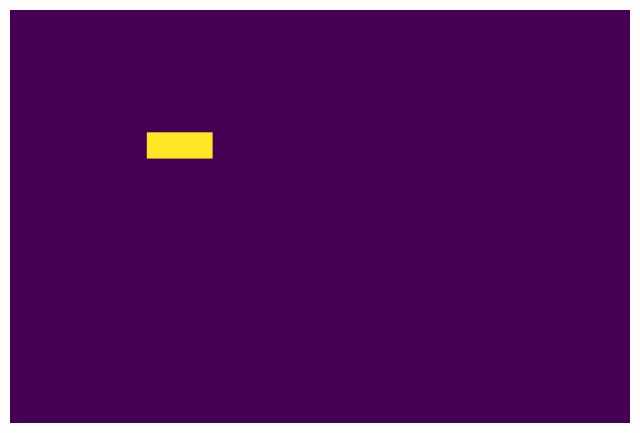

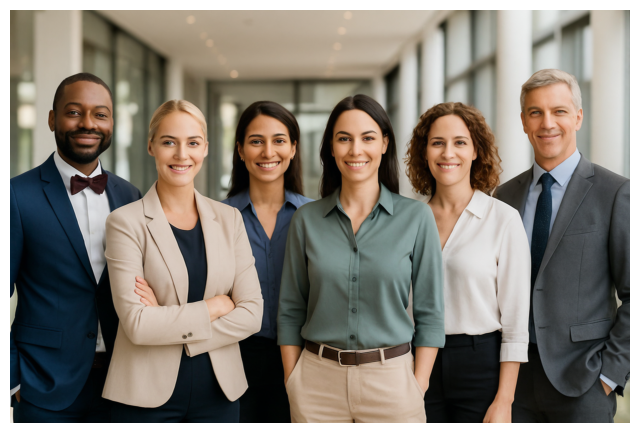

In [ ]:
from PIL import Image

W, H = image.size
result_img, mask = remove_glasses_sdxl(image, detections)

show_image(mask)
result_img = result_img.resize((W, H), Image.LANCZOS)  # <-- PIL resize
show_image(result_img)

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

# Segment Anything Model (SAM)

The Segment Anything Model (SAM) is a general-purpose image segmentation model created by Meta AI. Its main goal is to make segmentation as easy and flexible as possible, allowing users to segment any object in any image with simple prompts like points, boxes, or free-form masks.

Unlike traditional segmentation models that require task-specific training, SAM works in a prompt-based way:
you show the model what to segment, and it produces the mask instantly.

## What SAM Can Do

Point-based segmentation:
Click on an object to get its mask.

Box-based segmentation:
Draw a bounding box around an object and SAM segments it precisely.

Multiple object segmentation:
Detect and segment many objects in a scene.

Zero-shot performance:
Works on new objects and domains without fine-tuning.

Interactive editing:
Add more points to refine the mask (e.g., include/exclude areas).

### Init SAM model

In [ ]:
import torch, numpy as np, cv2
from PIL import Image
from transformers import SamModel, SamProcessor


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# --- Load SAM (choose huge/base depending on GPU) ---
sam_id = "facebook/sam-vit-base"   # lighter; or "facebook/sam-vit-huge" for best quality
sam_model = SamModel.from_pretrained(sam_id).to(device).eval()
sam_processor = SamProcessor.from_pretrained(sam_id)



Using device: cuda


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

### Use GroundingDino segmentation box to generate segmentation mask

[347.3984069824219, 313.96881103515625, 493.7066345214844, 361.57745361328125]


(np.float64(-0.5), np.float64(1535.5), np.float64(1023.5), np.float64(-0.5))

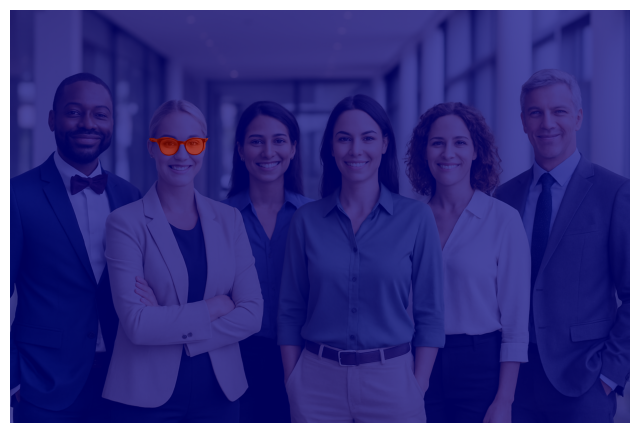

In [ ]:
bounding_box = detections['boxes'][0].detach().cpu().numpy().tolist()
print(bounding_box)

# --- Prepare inputs for SAM ---
inputs = sam_processor(
    image,
    input_boxes=[[bounding_box]],    # list of boxes
    return_tensors="pt"
).to(device)

# --- Forward pass through SAM ---
with torch.no_grad():
    outputs = sam_model(**inputs)

# SAM returns low-res logits; you must post-process them:
masks = sam_processor.post_process_masks(
    outputs.pred_masks.cpu(),      # [B, 1, H/4, W/4]
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)

mask = masks[0][0][0].numpy()  # final binary mask as numpy array

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.imshow(mask, alpha=0.7, cmap="jet")
plt.axis("off")

### Chose a point on image to prompt SAM

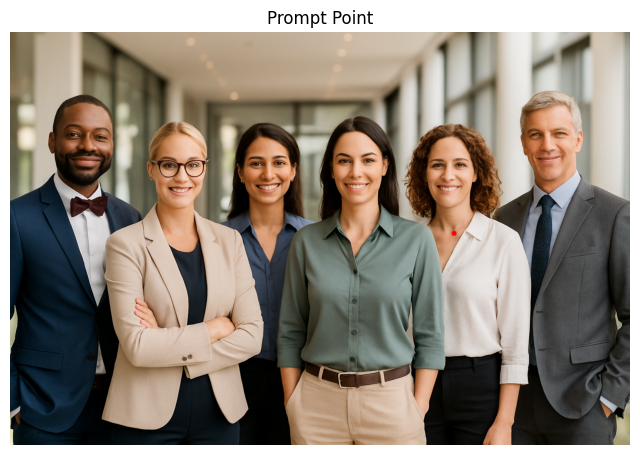

In [ ]:
def draw_point(img, point, color=(255,0,0)):
    img2 = img.copy()
    x, y = point
    cv2.circle(img2, (int(x), int(y)), 6, color, -1)
    return img2

show_image(draw_point(np.array(image), [1100, 500]), title="Prompt Point")

### SAM point based segmentaiton

(np.float64(-0.5), np.float64(1535.5), np.float64(1023.5), np.float64(-0.5))

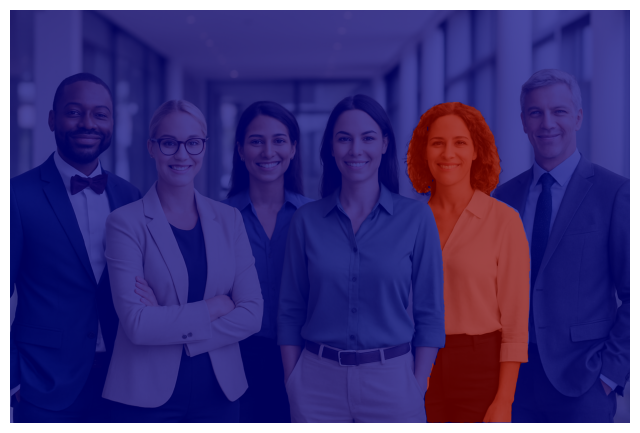

In [ ]:
# --- Prepare inputs for SAM ---
inputs = sam_processor(
    image,
    input_points=[[[1100, 500]]],    # list of points
    return_tensors="pt"
).to(device)

# --- Forward pass through SAM ---
with torch.no_grad():
    outputs = sam_model(**inputs)

# SAM returns logits
masks = sam_processor.post_process_masks(
    outputs.pred_masks.cpu(),      # [B, 1, H/4, W/4]
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)

mask = masks[0][0][0].numpy()  # final binary mask as numpy array

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.imshow(mask, alpha=0.7, cmap="jet")
plt.axis("off")

### Clear CUDA memory

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()